In [6]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [7]:
original_size_img = (1664, 1128)
half_size_img = (1177, 798)
five_percent_size_img = (372, 252)
two_half_size_img = (263, 178)

## Plotting Precision and Accuracy Function

In [8]:
def plot_loss_and_accuracy(results, final=False):
    
    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_precision = results.history['precision']
    val_precision = results.history['val_precision']
    train_accuracy = results.history['binary_accuracy']
    val_accuracy = results.history['val_binary_accuracy']

    # Setting up plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    #Plotting precision
    ax2.set_title("Precision")
    sns.lineplot(x=results.epoch, y=train_precision, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_precision, ax=ax2, label=val_label)
    ax2.legend()
    
    # Plotting accuracy info
    ax3.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax3, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax3, label=val_label)
    ax3.legend()

## Image Data Generator

In [9]:
# Directory path
train_data_dir = '../data/localdata/chest_xray/train'
test_data_dir = '../data/localdata/chest_xray/test'

# Get all the data in the directory data/localdata/chest_xray/test (624 images), and reshape them
training_generator = ImageDataGenerator(rescale=1/255, validation_split=0.25,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1/255)

train_set = training_generator.flow_from_directory(
        train_data_dir, target_size=(200, 200), batch_size=32, color_mode='grayscale', 
        class_mode='binary', seed=42, subset='training')

val_set = training_generator.flow_from_directory(
    train_data_dir, target_size=(200, 200), batch_size=32, color_mode='grayscale', 
         class_mode='binary', seed=42, subset='validation')

test_set = test_generator.flow_from_directory(
        test_data_dir, target_size=(200, 200), batch_size=32, color_mode='grayscale', class_mode='binary')

# Create the datasets
train_images, train_labels = next(train_set)
test_images, test_labels = next(test_set)

Found 4707 images belonging to 2 classes.
Found 1569 images belonging to 2 classes.
Found 1140 images belonging to 2 classes.


## First Complicated Model

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                       kernel_size=(3, 3),
                       activation='relu',
                       input_shape=(200, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', ))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', ))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Precision', 'BinaryAccuracy'])

early_stop = EarlyStopping(monitor='val_binary_accuracy', min_delta=0.001,
                           verbose=1, patience=4, restore_best_weights=True,
                           mode='auto')

results = model.fit(train_set, epochs=50, validation_data=val_set, callbacks=early_stop)

2023-09-12 17:49:52.454573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-12 17:49:52.454850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Epoch 1/50


2023-09-12 17:49:52.779991: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-12 17:49:53.032813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
plot_loss_and_accuracy(results)

In [ ]:
model.evaluate(test_set)

## Hybrid Augmentation with Lydia Best Model

In [10]:
best_model = models.Sequential()
best_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(200, 200, 1)))
best_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
best_model.add(layers.Flatten())
best_model.add(layers.Dense(64, activation='relu'))
best_model.add(layers.Dense(1, activation='sigmoid'))

best_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Precision', 'BinaryAccuracy'])

checkpoint_path = "best_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stop = EarlyStopping(monitor='val_binary_accuracy', min_delta=0.001,
                           verbose=1, patience=4, restore_best_weights=True,
                           mode='auto')

results_best = best_model.fit(train_set, epochs=50, validation_data=val_set,
                    callbacks=[ early_stop])

Epoch 1/50


2023-09-12 17:50:11.995789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


148/148 [==============================] - ETA: 0s - loss: 0.5533 - precision: 0.8447 - binary_accuracy: 0.8009

2023-09-12 17:50:41.408638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


148/148 [==============================] - 37s 250ms/step - loss: 0.5533 - precision: 0.8447 - binary_accuracy: 0.8009 - val_loss: 0.3459 - val_precision: 0.8199 - val_binary_accuracy: 0.8196
Epoch 2/50
148/148 [==============================] - 35s 237ms/step - loss: 0.3257 - precision: 0.8881 - binary_accuracy: 0.8579 - val_loss: 0.2780 - val_precision: 0.8624 - val_binary_accuracy: 0.8572
Epoch 3/50
148/148 [==============================] - 36s 240ms/step - loss: 0.2918 - precision: 0.9014 - binary_accuracy: 0.8687 - val_loss: 0.2471 - val_precision: 0.9679 - val_binary_accuracy: 0.9012
Epoch 4/50
148/148 [==============================] - 36s 245ms/step - loss: 0.2744 - precision: 0.9082 - binary_accuracy: 0.8783 - val_loss: 0.2337 - val_precision: 0.9233 - val_binary_accuracy: 0.9089
Epoch 5/50
148/148 [==============================] - 35s 236ms/step - loss: 0.2560 - precision: 0.9249 - binary_accuracy: 0.8934 - val_loss: 0.2233 - val_precision: 0.9096 - val_binary_accuracy: 0.9

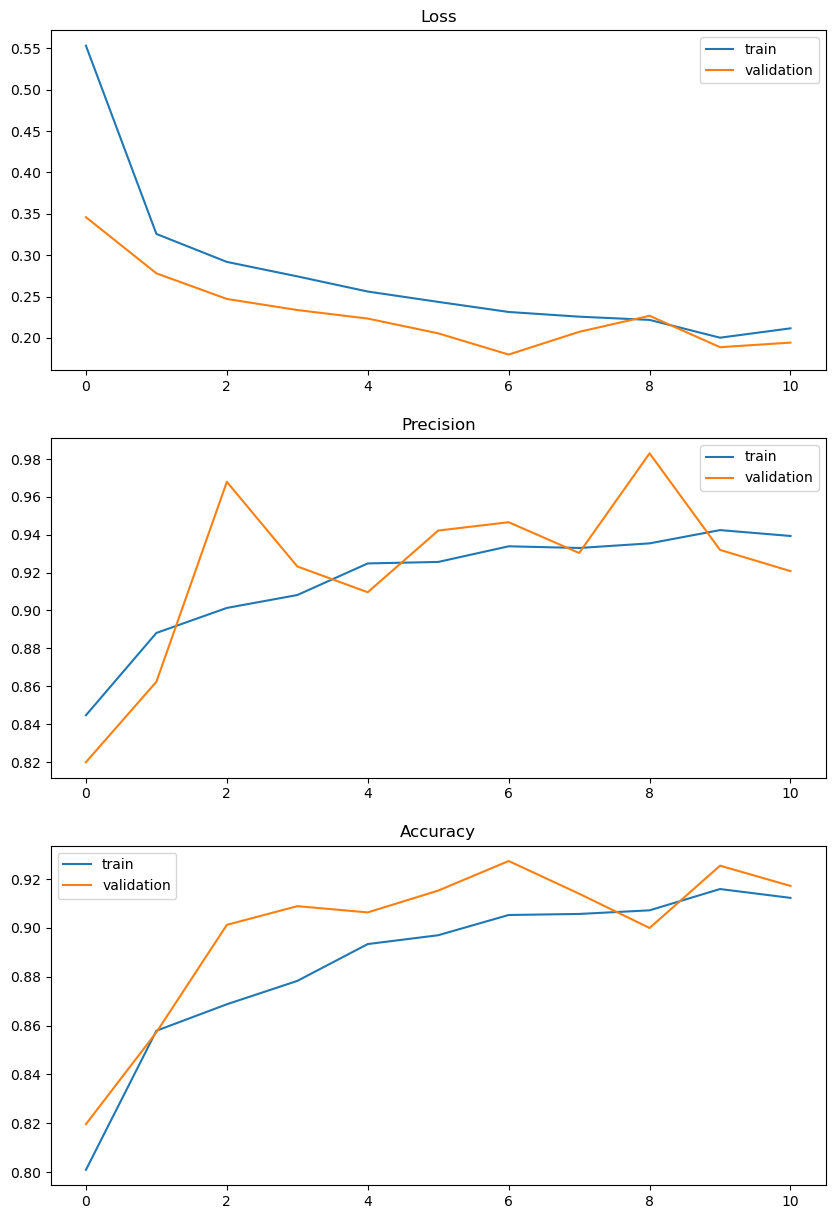

In [11]:
plot_loss_and_accuracy(results_best)

In [12]:
best_model.evaluate(test_set)

36/36 [==============================] - 5s 127ms/step - loss: 0.5289 - precision: 0.7592 - binary_accuracy: 0.8009


[0.5289011597633362, 0.7591743469238281, 0.8008772134780884]

## Simple Model (CNN)